#1.Import library and import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.nn import LogSoftmax
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.models.resnet import resnet50,resnet34
# from torchsummary import summary
import cv2
from torch.cuda.amp import GradScaler, autocast
#"/content/drive/MyDrive/Facial expression regcogconition/CK+48"
from torchvision.io import read_image


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Facial expression regcogconition/fer2013/fer2013.csv")

#2.Specify hyperparameters

In [ ]:
# Hyperparamters:
epochs = 100

# batch_size
batch_size = 64

#learning_rate:
learning_rate = 0.03

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


checkpoint_path = '/kaggle/working/Express_model.pth'

#3.Custom Datasets

In [7]:
class custom_datasets(Dataset):
  def __init__(self,dataframe,transform = None):
    super().__init__()
    self.data = dataframe
    self.transform = transform



  def change_to_image(self,x):
    img = np.array(x.split(),dtype = np.int8)
    img = img.reshape((48,48))
    img = Image.fromarray(img)
    return img

  def __getitem__(self,index):
    image = self.change_to_image(self.data.loc[index,"pixels"])
    label = self.data.loc[index, "emotion"]
    if self.transform:
      image = self.transform(image)

    return (image,label)



  def __len__(self):
    return self.data.index.size






In [55]:
mu, st = 0, 255
# test transforms:
test_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack(
            [transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack(
            [transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

# Train_transforms:

train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
            transforms.RandomApply(
                [transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.FiveCrop(40),
            transforms.Lambda(lambda crops: torch.stack(
                [transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack(
                [transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack(
                [transforms.RandomErasing()(t) for t in tensors])),
        ])

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [9]:
train = data[data.loc[:,"Usage"] == "Training"].loc[:,:]
valid = data[data.loc[:,"Usage"] == "PublicTest"]
valid.index = range(0,valid.index.size)
test = data[data.loc[:,"Usage"] == "PrivateTest"]
test.index = range(0,test.index.size)



train_datasets = custom_datasets(dataframe = train,transform = train_transform)
valid_datasets = custom_datasets(dataframe = valid,transform = test_transform)
test_datasets = custom_datasets(dataframe = test,transform = test_transform)

In [56]:
predict_datasets = custom_datasets(dataframe = test,transform = transform)
predict_dataloader_train = DataLoader(test_datasets, batch_size = 8, shuffle = False)
predict_dataloader_print = DataLoader(predict_datasets, batch_size = 8, shuffle = False)

In [11]:
train_dataloader = DataLoader(train_datasets, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_datasets, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_datasets, batch_size = batch_size, shuffle = False)

#3.Build Model

In [12]:
class Residual(nn.Module):
  """The Residual block of ResNet models."""
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
    stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
      stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [13]:
# model
class ResNet(nn.Module):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.LazyLinear(num_classes)))


  def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual(num_channels))
    return nn.Sequential(*blk)


  def b1(self):
    return nn.Sequential(
    nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
    nn.LazyBatchNorm2d(), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

  def forward(self,X):
    return self.net(X)

In [14]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=7):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
    lr, num_classes)


#4.Training

In [15]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [16]:
#model
model = ResNet18()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentu

In [19]:
# compute accuracy
def accuracy(outputs, targets):
    predicted_class = torch.argmax(outputs, dim = 1)
    boolean = []
    for i in range(len(targets)):
        if predicted_class[i] == targets[i]:
            boolean.append(1)
        else:
            boolean.append(0)
    return sum(boolean)/len(boolean)

In [ ]:
def fit_epoch(epoch, model, optimizer,train_dataloader):
  loss_epochs = 0
  acc_epochs = 0
  print(f"learning_rate:{optimizer.param_groups[0]['lr']}" )
  for img, label in tqdm(train_dataloader):
    with autocast():
        bs,nCrop,c,h,w = img.shape
        img = img.view(-1,c,h,w)

        label = torch.repeat_interleave(label, repeats=nCrop, dim=0)

        # Change in into gpu:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        # feed forward data:
        outputs = model(img)

        # loss function:
        loss = loss_fn(outputs, label)

    # optimizer step:
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


    #gather loss metrics:
    loss_epochs += loss.item()
    acc_epochs += accuracy(outputs, label)

  print(f"Epoch {epoch + 1}: train_loss: {loss_epochs/len(train_dataloader)}, train_acc: {acc_epochs/len(train_dataloader)}")
  return loss_epochs/len(train_dataloader),acc_epochs/len(train_dataloader)

In [20]:
#Specify loss function and optimizer:
loss_fn = nn.CrossEntropyLoss()

# optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4, nesterov=True)

# learning_rate scheduler:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size =15 ,gamma = 0.1)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
             optimizer, mode='max', factor=0.75, patience=5, verbose=True)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             optimizer, T_max=epochs)

scaler = GradScaler()


In [ ]:
save_model(model, optimizer, checkpoint_path)

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
  print(f"Epoch {epoch + 1}:")
  model.train(True)

  t_loss, t_acc = fit_epoch(epoch,model,optimizer,train_dataloader)
  train_loss.append(t_loss)
  train_acc.append(t_acc)

  # valid evaluation:

  model.eval()
  valid_loss = 0
  valid_acc = 0
  last_acc = 0
  with torch.no_grad():
    for img, label in valid_dataloader:
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      vloss = loss_fn(outputs, label)
      valid_loss += vloss.item()
      valid_acc += accuracy(outputs,label)

    val_loss.append(valid_loss/len(valid_dataloader))
    valid_accuracy = valid_acc/len(valid_dataloader)
    val_acc.append(valid_accuracy)

  print(f"Epoch {epoch + 1}: valid_loss: {valid_loss/len(valid_dataloader)}, valid_acc: {valid_accuracy}")

  if valid_accuracy > last_acc:
        save_model(model, optimizer, checkpoint_path)
        last_acc = valid_accuracy


  scheduler.step(valid_accuracy)







Epoch 1:
learning_rate:0.03


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 1: train_loss: 1.8482835943290015, train_acc: 0.2408174321314631
Epoch 1: valid_loss: 1.7541601176847492, valid_acc: 0.28503289473684207
Epoch 2:
learning_rate:0.03


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 2: train_loss: 1.7442758492212784, train_acc: 0.2879145849635828
Epoch 2: valid_loss: 1.7894811211970814, valid_acc: 0.29692982456140354
Epoch 3:
learning_rate:0.03


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 3: train_loss: 1.6460972153529823, train_acc: 0.34385759646060304
Epoch 3: valid_loss: 1.5280700273681105, valid_acc: 0.4099232456140351
Epoch 4:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.94it/s]


Epoch 4: train_loss: 1.5478861321319717, train_acc: 0.391005725937519
Epoch 4: valid_loss: 1.45495889688793, valid_acc: 0.4354166666666667
Epoch 5:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.93it/s]


Epoch 5: train_loss: 1.4779258852281125, train_acc: 0.4239392719556974
Epoch 5: valid_loss: 1.7475266289292721, valid_acc: 0.29161184210526314
Epoch 6:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 6: train_loss: 1.425561496303448, train_acc: 0.4520275913441283
Epoch 6: valid_loss: 1.4814019370497318, valid_acc: 0.43760964912280703
Epoch 7:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 7: train_loss: 1.3848257571923441, train_acc: 0.46749288960452695
Epoch 7: valid_loss: 1.313749024742528, valid_acc: 0.47911184210526314
Epoch 8:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.90it/s]


Epoch 8: train_loss: 1.3550755592656294, train_acc: 0.4801546605068322
Epoch 8: valid_loss: 1.2713208679567303, valid_acc: 0.5174342105263158
Epoch 9:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.88it/s]


Epoch 9: train_loss: 1.3266620739531145, train_acc: 0.4925132050201648
Epoch 9: valid_loss: 1.4456068737465038, valid_acc: 0.46787280701754386
Epoch 10:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 10: train_loss: 1.3044488047703868, train_acc: 0.502704771865407
Epoch 10: valid_loss: 1.5344010591506958, valid_acc: 0.38837719298245615
Epoch 11:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 11: train_loss: 1.2820514522841353, train_acc: 0.5112970640462284
Epoch 11: valid_loss: 1.4128152675795973, valid_acc: 0.4417763157894737
Epoch 12:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 12: train_loss: 1.2690169848418713, train_acc: 0.5152990128212844
Epoch 12: valid_loss: 1.265174338692113, valid_acc: 0.5154057017543859
Epoch 13:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.91it/s]


Epoch 13: train_loss: 1.25462381956572, train_acc: 0.5220875594414008
Epoch 13: valid_loss: 1.2680262348108124, valid_acc: 0.5155701754385965
Epoch 14:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 14: train_loss: 1.237269820110304, train_acc: 0.5307846264973216
Epoch 14: valid_loss: 1.2233918643834298, valid_acc: 0.5282894736842105
Epoch 15:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 15: train_loss: 1.2269472858157084, train_acc: 0.5323058372960932
Epoch 15: valid_loss: 1.4028911109556232, valid_acc: 0.44731359649122804
Epoch 16:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.88it/s]


Epoch 16: train_loss: 1.2125727883426012, train_acc: 0.5389659077228673
Epoch 16: valid_loss: 1.1245198709922923, valid_acc: 0.5848135964912281
Epoch 17:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.88it/s]


Epoch 17: train_loss: 1.2016636589853165, train_acc: 0.5438037982303016
Epoch 17: valid_loss: 1.126459633049212, valid_acc: 0.5723135964912281
Epoch 18:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 18: train_loss: 1.1906953655797283, train_acc: 0.5478095091193642
Epoch 18: valid_loss: 1.1652414851021349, valid_acc: 0.5604714912280702
Epoch 19:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.94it/s]


Epoch 19: train_loss: 1.1821159931492964, train_acc: 0.5533400048155059
Epoch 19: valid_loss: 1.1057912257679723, valid_acc: 0.5824013157894736
Epoch 20:
learning_rate:0.03


100%|██████████| 449/449 [01:54<00:00,  3.93it/s]


Epoch 20: train_loss: 1.1786475782936028, train_acc: 0.5516047297297294
Epoch 20: valid_loss: 1.1434657040395235, valid_acc: 0.5642543859649123
Epoch 21:
learning_rate:0.03


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 21: train_loss: 1.1686476028310695, train_acc: 0.5581624706555108
Epoch 21: valid_loss: 1.0954326391220093, valid_acc: 0.5839912280701754
Epoch 22:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.86it/s]


Epoch 22: train_loss: 1.1578454835908716, train_acc: 0.5591156022392108
Epoch 22: valid_loss: 1.0889251985047992, valid_acc: 0.590844298245614
Epoch 23:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.86it/s]


Epoch 23: train_loss: 1.1490905634013475, train_acc: 0.5653545040028893
Epoch 23: valid_loss: 1.036468742186563, valid_acc: 0.6079495614035089
Epoch 24:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.87it/s]


Epoch 24: train_loss: 1.1408668196280973, train_acc: 0.5679494221392888
Epoch 24: valid_loss: 1.144442920099225, valid_acc: 0.5601973684210526
Epoch 25:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.85it/s]


Epoch 25: train_loss: 1.1372234002253525, train_acc: 0.5689317101065431
Epoch 25: valid_loss: 1.1370095819757695, valid_acc: 0.575
Epoch 26:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.87it/s]


Epoch 26: train_loss: 1.1315086065793623, train_acc: 0.5710495921868418
Epoch 26: valid_loss: 1.1081289554897107, valid_acc: 0.5775219298245614
Epoch 27:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.86it/s]


Epoch 27: train_loss: 1.1215092097730572, train_acc: 0.5738348732920009
Epoch 27: valid_loss: 1.0907173041711773, valid_acc: 0.5878289473684211
Epoch 28:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.84it/s]


Epoch 28: train_loss: 1.1166982126395262, train_acc: 0.5766957728887016
Epoch 28: valid_loss: 1.0779859235412197, valid_acc: 0.5917214912280702
Epoch 29:
learning_rate:0.03


100%|██████████| 449/449 [01:56<00:00,  3.85it/s]


Epoch 29: train_loss: 1.1116540611188501, train_acc: 0.5794752227171488
Epoch 29: valid_loss: 1.0653252225173147, valid_acc: 0.5928179824561404
Epoch 00029: reducing learning rate of group 0 to 2.2500e-02.
Epoch 30:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.87it/s]


Epoch 30: train_loss: 1.0840580865641214, train_acc: 0.5901637648227296
Epoch 30: valid_loss: 1.0234562064471997, valid_acc: 0.6207785087719297
Epoch 31:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 31: train_loss: 1.0759056871611716, train_acc: 0.5939051872027927
Epoch 31: valid_loss: 0.9852484360075834, valid_acc: 0.6270285087719298
Epoch 32:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.87it/s]


Epoch 32: train_loss: 1.072558666257922, train_acc: 0.5948545566724855
Epoch 32: valid_loss: 1.1067075384290594, valid_acc: 0.5793859649122807
Epoch 33:
learning_rate:0.0225


100%|██████████| 449/449 [01:56<00:00,  3.87it/s]


Epoch 33: train_loss: 1.0722954813515424, train_acc: 0.5932426789261422
Epoch 33: valid_loss: 0.9656248688697815, valid_acc: 0.6336074561403509
Epoch 34:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.88it/s]


Epoch 34: train_loss: 1.0658508191395444, train_acc: 0.5965016101847944
Epoch 34: valid_loss: 1.068078518959514, valid_acc: 0.5873355263157894
Epoch 35:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.89it/s]


Epoch 35: train_loss: 1.061355340719754, train_acc: 0.5988977005959183
Epoch 35: valid_loss: 0.9921978001008954, valid_acc: 0.6251096491228071
Epoch 36:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.87it/s]


Epoch 36: train_loss: 1.058939084311105, train_acc: 0.5990914494672844
Epoch 36: valid_loss: 1.0467051947325992, valid_acc: 0.6126644736842105
Epoch 37:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 37: train_loss: 1.0571553976604826, train_acc: 0.601894224402576
Epoch 37: valid_loss: 1.0719577701468217, valid_acc: 0.6037280701754386
Epoch 38:
learning_rate:0.0225


100%|██████████| 449/449 [01:56<00:00,  3.85it/s]


Epoch 38: train_loss: 1.053247879767471, train_acc: 0.6005566047673503
Epoch 38: valid_loss: 1.00696644552967, valid_acc: 0.6265350877192982
Epoch 39:
learning_rate:0.0225


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 39: train_loss: 1.0464414196184324, train_acc: 0.6036014717389996
Epoch 39: valid_loss: 1.1331463247014766, valid_acc: 0.5777412280701754
Epoch 00039: reducing learning rate of group 0 to 1.6875e-02.
Epoch 40:
learning_rate:0.016875


100%|██████████| 449/449 [01:55<00:00,  3.88it/s]


Epoch 40: train_loss: 1.0278359853345196, train_acc: 0.6106330509239752
Epoch 40: valid_loss: 0.9506500091469079, valid_acc: 0.6456688596491228
Epoch 41:
learning_rate:0.016875


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 41: train_loss: 1.0203967525858124, train_acc: 0.6141859913922838
Epoch 41: valid_loss: 1.040728669417532, valid_acc: 0.6081688596491228
Epoch 42:
learning_rate:0.016875


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 42: train_loss: 1.0170788514056557, train_acc: 0.6150697119725514
Epoch 42: valid_loss: 1.074969680685746, valid_acc: 0.5925438596491228
Epoch 43:
learning_rate:0.016875


100%|██████████| 449/449 [01:53<00:00,  3.94it/s]


Epoch 43: train_loss: 1.0071978052634174, train_acc: 0.618637324685487
Epoch 43: valid_loss: 0.9296737972058748, valid_acc: 0.6585526315789474
Epoch 44:
learning_rate:0.016875


100%|██████████| 449/449 [01:54<00:00,  3.94it/s]


Epoch 44: train_loss: 1.0070986654816863, train_acc: 0.6202362231385065
Epoch 44: valid_loss: 0.9330422491358038, valid_acc: 0.6541118421052631
Epoch 45:
learning_rate:0.016875


100%|██████████| 449/449 [01:55<00:00,  3.90it/s]


Epoch 45: train_loss: 1.0053319867310386, train_acc: 0.6219489255402391
Epoch 45: valid_loss: 0.9790304229970563, valid_acc: 0.6333881578947368
Epoch 46:
learning_rate:0.016875


100%|██████████| 449/449 [01:54<00:00,  3.92it/s]


Epoch 46: train_loss: 1.002656348033047, train_acc: 0.6210968067176302
Epoch 46: valid_loss: 1.0012639687772382, valid_acc: 0.6360197368421052
Epoch 47:
learning_rate:0.016875


100%|██████████| 449/449 [01:54<00:00,  3.93it/s]


Epoch 47: train_loss: 0.997418400970493, train_acc: 0.6232316183109617
Epoch 47: valid_loss: 0.9507890646917778, valid_acc: 0.643530701754386
Epoch 48:
learning_rate:0.016875


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 48: train_loss: 1.0030444909575786, train_acc: 0.6206662327695182
Epoch 48: valid_loss: 0.9351822399256522, valid_acc: 0.649780701754386
Epoch 49:
learning_rate:0.016875


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 49: train_loss: 0.9880562545462016, train_acc: 0.6264299795340998
Epoch 49: valid_loss: 1.0282469099028069, valid_acc: 0.6150219298245614
Epoch 00049: reducing learning rate of group 0 to 1.2656e-02.
Epoch 50:
learning_rate:0.01265625


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 50: train_loss: 0.973516906290118, train_acc: 0.632998630590502
Epoch 50: valid_loss: 0.9390503481814736, valid_acc: 0.6615679824561403
Epoch 51:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 51: train_loss: 0.966166216705849, train_acc: 0.6358589658701015
Epoch 51: valid_loss: 0.911006210143106, valid_acc: 0.668640350877193
Epoch 52:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 52: train_loss: 0.9649788157180582, train_acc: 0.6379608589658698
Epoch 52: valid_loss: 1.0451002737932038, valid_acc: 0.621765350877193
Epoch 53:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 53: train_loss: 0.9651661811267879, train_acc: 0.6369321088906272
Epoch 53: valid_loss: 0.9227102200190226, valid_acc: 0.6566337719298246
Epoch 54:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 54: train_loss: 0.9534592300587083, train_acc: 0.6406993017516402
Epoch 54: valid_loss: 0.9260539307928922, valid_acc: 0.6588267543859649
Epoch 55:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 55: train_loss: 0.9540046230456346, train_acc: 0.6403195163426233
Epoch 55: valid_loss: 0.9671247988416437, valid_acc: 0.6442982456140351
Epoch 56:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 56: train_loss: 0.9545771884493414, train_acc: 0.6402422048997769
Epoch 56: valid_loss: 0.9344534664823297, valid_acc: 0.6459978070175438
Epoch 57:
learning_rate:0.01265625


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 57: train_loss: 0.9521123226607563, train_acc: 0.6404767727081196
Epoch 57: valid_loss: 0.956094785740501, valid_acc: 0.6456688596491228
Epoch 00057: reducing learning rate of group 0 to 9.4922e-03.
Epoch 58:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 58: train_loss: 0.9374866036901496, train_acc: 0.6467642057424909
Epoch 58: valid_loss: 0.9236884660888136, valid_acc: 0.6591008771929825
Epoch 59:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 59: train_loss: 0.9255322559108182, train_acc: 0.650864157587432
Epoch 59: valid_loss: 0.9338347054364389, valid_acc: 0.6558662280701754
Epoch 60:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 60: train_loss: 0.9229196926002248, train_acc: 0.6530313233612236
Epoch 60: valid_loss: 0.8989843339250799, valid_acc: 0.6701206140350877
Epoch 61:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 61: train_loss: 0.9215807989073755, train_acc: 0.6514068425329558
Epoch 61: valid_loss: 0.8943828072464257, valid_acc: 0.6613486842105263
Epoch 62:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 62: train_loss: 0.9152095357665506, train_acc: 0.6553243318485518
Epoch 62: valid_loss: 0.9105834417175829, valid_acc: 0.6607456140350877
Epoch 63:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 63: train_loss: 0.9173564657336619, train_acc: 0.6539125985673869
Epoch 63: valid_loss: 0.9338407129572149, valid_acc: 0.653015350877193
Epoch 64:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 64: train_loss: 0.9116157680949017, train_acc: 0.6568457307530247
Epoch 64: valid_loss: 0.8991212144232633, valid_acc: 0.6613486842105263
Epoch 65:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 65: train_loss: 0.9140621272386581, train_acc: 0.6555391485583582
Epoch 65: valid_loss: 0.9299643175643787, valid_acc: 0.6495614035087719
Epoch 66:
learning_rate:0.0094921875


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 66: train_loss: 0.9137623612758577, train_acc: 0.6559027568771453
Epoch 66: valid_loss: 0.9276655661432367, valid_acc: 0.6539473684210526
Epoch 00066: reducing learning rate of group 0 to 7.1191e-03.
Epoch 67:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 67: train_loss: 0.8884328554627093, train_acc: 0.6657801872027933
Epoch 67: valid_loss: 0.9129056282210768, valid_acc: 0.6741228070175438
Epoch 68:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 68: train_loss: 0.8884226366512494, train_acc: 0.6648063639920548
Epoch 68: valid_loss: 0.9125494810572842, valid_acc: 0.6651864035087719
Epoch 69:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.97it/s]


Epoch 69: train_loss: 0.8829499914545259, train_acc: 0.6687029735749113
Epoch 69: valid_loss: 0.9158791261806822, valid_acc: 0.6675986842105264
Epoch 70:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 70: train_loss: 0.8780540484097062, train_acc: 0.6703193658580632
Epoch 70: valid_loss: 0.921296148969416, valid_acc: 0.6610745614035087
Epoch 71:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 71: train_loss: 0.8798328668609229, train_acc: 0.6676973605008129
Epoch 71: valid_loss: 0.9101259760689318, valid_acc: 0.6809758771929824
Epoch 72:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 72: train_loss: 0.87828898204196, train_acc: 0.6688609823632093
Epoch 72: valid_loss: 0.9327996299977888, valid_acc: 0.6640350877192983
Epoch 73:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 73: train_loss: 0.8748722647240008, train_acc: 0.6712102344549454
Epoch 73: valid_loss: 0.8898516245055617, valid_acc: 0.6725877192982456
Epoch 74:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 74: train_loss: 0.8746261721464467, train_acc: 0.6712038388611327
Epoch 74: valid_loss: 0.9093584648349828, valid_acc: 0.6706688596491228
Epoch 75:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 75: train_loss: 0.872505120153151, train_acc: 0.6715791097333412
Epoch 75: valid_loss: 0.902506408984201, valid_acc: 0.6708881578947369
Epoch 76:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 76: train_loss: 0.8708715896829465, train_acc: 0.6714115075543249
Epoch 76: valid_loss: 0.9373242102171245, valid_acc: 0.6555921052631579
Epoch 77:
learning_rate:0.007119140625000001


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 77: train_loss: 0.8671899868013598, train_acc: 0.6745553181243608
Epoch 77: valid_loss: 0.9027014113309091, valid_acc: 0.66875
Epoch 00077: reducing learning rate of group 0 to 5.3394e-03.
Epoch 78:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  3.98it/s]


Epoch 78: train_loss: 0.8536404454893949, train_acc: 0.6782472687052306
Epoch 78: valid_loss: 0.8939870899183708, valid_acc: 0.6706688596491228
Epoch 79:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 79: train_loss: 0.8468862258246322, train_acc: 0.6804511150905919
Epoch 79: valid_loss: 0.8878804968114484, valid_acc: 0.6805372807017543
Epoch 80:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  4.00it/s]


Epoch 80: train_loss: 0.8497038907091442, train_acc: 0.681089545837597
Epoch 80: valid_loss: 0.9051217750499123, valid_acc: 0.6692982456140351
Epoch 81:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 81: train_loss: 0.8430811611475021, train_acc: 0.6835864609041117
Epoch 81: valid_loss: 0.9175892785975808, valid_acc: 0.6739035087719298
Epoch 82:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 82: train_loss: 0.8368404082837774, train_acc: 0.6849447721663756
Epoch 82: valid_loss: 0.9000095589119091, valid_acc: 0.6850877192982455
Epoch 83:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:54<00:00,  3.92it/s]


Epoch 83: train_loss: 0.842598080502321, train_acc: 0.6846112607596463
Epoch 83: valid_loss: 0.9367879995128565, valid_acc: 0.66875
Epoch 84:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 84: train_loss: 0.8340394242038175, train_acc: 0.6881322232588938
Epoch 84: valid_loss: 0.8957293901527137, valid_acc: 0.6701206140350877
Epoch 85:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:52<00:00,  3.99it/s]


Epoch 85: train_loss: 0.8377864310364416, train_acc: 0.68605384337567
Epoch 85: valid_loss: 0.918971278165516, valid_acc: 0.6675986842105264
Epoch 86:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 86: train_loss: 0.8341730489231696, train_acc: 0.685470715704569
Epoch 86: valid_loss: 0.9111557069577669, valid_acc: 0.6722587719298246
Epoch 87:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 87: train_loss: 0.8357198932654077, train_acc: 0.6864676759164511
Epoch 87: valid_loss: 0.9023510301322267, valid_acc: 0.684046052631579
Epoch 88:
learning_rate:0.005339355468750001


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 88: train_loss: 0.8275129757904528, train_acc: 0.6903862938662496
Epoch 88: valid_loss: 0.9192302791695846, valid_acc: 0.680921052631579
Epoch 00088: reducing learning rate of group 0 to 4.0045e-03.
Epoch 89:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 89: train_loss: 0.814452336466392, train_acc: 0.693878288087642
Epoch 89: valid_loss: 0.8968043630583244, valid_acc: 0.6796600877192983
Epoch 90:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 90: train_loss: 0.8131646946703139, train_acc: 0.6951169641244805
Epoch 90: valid_loss: 0.8928258230811671, valid_acc: 0.6786184210526316
Epoch 91:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 91: train_loss: 0.8090454062534069, train_acc: 0.6958550908926744
Epoch 91: valid_loss: 0.9004513527217665, valid_acc: 0.6838267543859649
Epoch 92:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.94it/s]


Epoch 92: train_loss: 0.8097103822204743, train_acc: 0.6958970384638531
Epoch 92: valid_loss: 0.9085018875306112, valid_acc: 0.6791666666666667
Epoch 93:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.94it/s]


Epoch 93: train_loss: 0.8026819089738723, train_acc: 0.6986407482092334
Epoch 93: valid_loss: 0.9082476956802502, valid_acc: 0.6895285087719298
Epoch 94:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 94: train_loss: 0.8026801581372132, train_acc: 0.6981195073135495
Epoch 94: valid_loss: 0.9164033228890938, valid_acc: 0.6850877192982455
Epoch 95:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 95: train_loss: 0.8027336885509618, train_acc: 0.6991518313970981
Epoch 95: valid_loss: 0.9276628337408367, valid_acc: 0.6834429824561403
Epoch 96:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 96: train_loss: 0.8043617875645049, train_acc: 0.6982897429723709
Epoch 96: valid_loss: 0.9056887741674456, valid_acc: 0.6797149122807017
Epoch 97:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.96it/s]


Epoch 97: train_loss: 0.7954540835457018, train_acc: 0.7014469090471313
Epoch 97: valid_loss: 0.9151885885941354, valid_acc: 0.674780701754386
Epoch 98:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.97it/s]


Epoch 98: train_loss: 0.7968190103968427, train_acc: 0.6995308643833142
Epoch 98: valid_loss: 0.9255801596139607, valid_acc: 0.6829495614035088
Epoch 99:
learning_rate:0.004004516601562501


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 99: train_loss: 0.7978046531135627, train_acc: 0.7012044407993738
Epoch 99: valid_loss: 0.9228755653950206, valid_acc: 0.6804824561403509
Epoch 00099: reducing learning rate of group 0 to 3.0034e-03.
Epoch 100:
learning_rate:0.0030033874511718756


100%|██████████| 449/449 [01:53<00:00,  3.95it/s]


Epoch 100: train_loss: 0.7851024049693067, train_acc: 0.7054245921868417
Epoch 100: valid_loss: 0.9217376824010882, valid_acc: 0.6876096491228071


#5.Graph and predict

In [ ]:
epoch_range = range(1,epochs+1)

In [ ]:
last_acc

0.6876096491228071

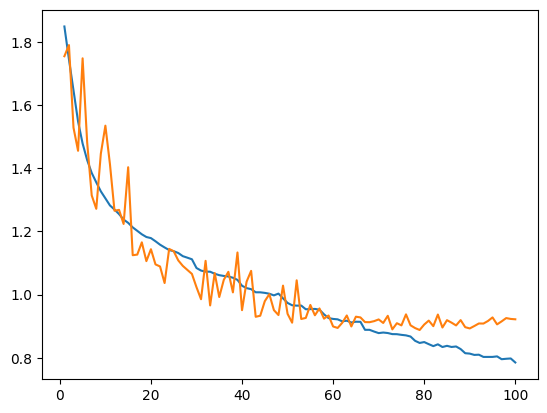

In [ ]:
plt.plot(epoch_range, train_loss)
plt.plot(epoch_range, val_loss)
plt.show()

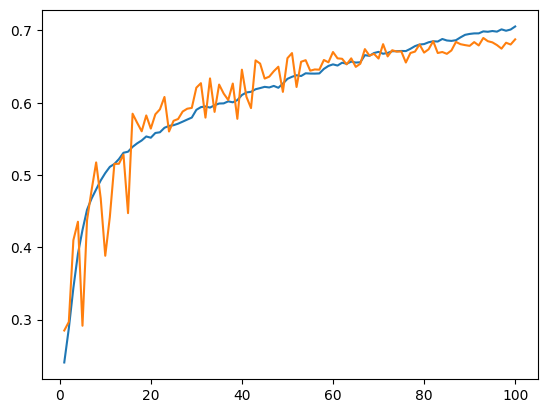

In [ ]:
plt.plot(epoch_range, train_acc)
plt.plot(epoch_range, val_acc)
plt.show()

In [24]:
#load_model
model_load, optimizer_load = load_model(model,optimizer,"/content/drive/MyDrive/Facial expression regcogconition/Express_model (4).pth")


In [25]:
data_test = valid_dataloader
#test_acc:
test_loss = 0
test_acc = 0
with torch.no_grad():
    for img, label in tqdm(data_test):
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model_load(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      tloss = loss_fn(outputs, label)
      test_loss += tloss.item()
      test_acc += accuracy(outputs,label)

    test_accuracy = test_acc/len(data_test)


    print(f"valid_loss: {test_loss/len(data_test)}, valid_acc: {test_accuracy}")


100%|██████████| 57/57 [00:11<00:00,  4.94it/s]

valid_loss: 0.8801133549004271, valid_acc: 0.6985745614035088


In [42]:
data_test = test_dataloader
#test_acc:
test_loss = 0
test_acc = 0
with torch.no_grad():
    for img, label in tqdm(data_test):
      bs,nCrop,c,h,w = img.shape
      img = img.view(-1,c,h,w)

      img = img.to(device)
      label = label.to(device)

      outputs = model_load(img)

      outputs = outputs.view(bs, nCrop, -1)
      outputs = torch.sum(outputs, dim=1) / nCrop

      tloss = loss_fn(outputs, label)
      test_loss += tloss.item()
      test_acc += accuracy(outputs,label)

    test_accuracy = test_acc/len(data_test)


    print(f"test_loss: {test_loss/len(data_test)}, test_acc: {test_accuracy}")

100%|██████████| 57/57 [00:12<00:00,  4.60it/s]

test_loss: 0.8382516451049269, test_acc: 0.700438596491228


In [27]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
change = {0:"Angry", 1: "Disgust",2 :"fear", 3:"Happy", 4:"Sad", 5:"Suprise", 6: "Neutral"}

In [133]:
pd = enumerate(predict_dataloader_train)
pd1 = enumerate(predict_dataloader_print)

In [134]:
#Prediction:
def predict(image_batch,image_batch_print,model, label):
    bs,nCrop,c,h,w = image_batch.shape
    image_batch = image_batch.view(-1,c,h,w)
    outputs = model(image_batch.to(device))
    outputs = outputs.view(bs, nCrop, -1)
    outputs = torch.sum(outputs, dim=1) / nCrop
    predicted_class = torch.argmax(outputs, dim = 1)


    fig, axs = plt.subplots(8,1, figsize=(10, 40))
    batch_size = image_batch_print.shape[0]
    for index in range(batch_size):
         axs[index].imshow(image_batch_print[index].permute(1,2,0))
         axs[index].set_title(f'Predict: {change[int(predicted_class[index])]} - Label: {change[int(label[index])]} ')
    plt.show()



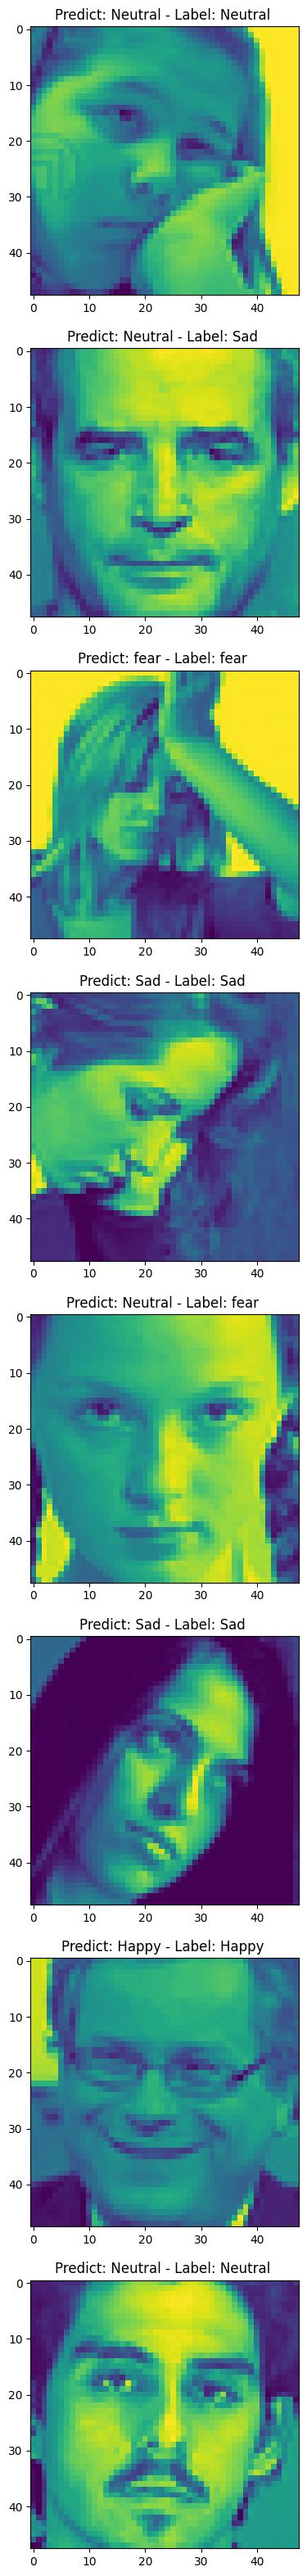

In [140]:
i,(ib,l) = next(pd)
k, (ib1,l1) = next(pd1)
predict(ib,ib1,model_load,l)

In [127]:
img1 = np.array(read_image("/content/OIP.jpg"))
img1 = img1.reshape((img1.shape[1],img1.shape[2],img1.shape[0]))
img2 = Image.fromarray(img1)

In [128]:
transform_test = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48,48)),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack(
            [transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack(
            [transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

In [129]:
img2_t = transform_test(img2)

In [130]:
img2_t = img2_t.unsqueeze(0)

In [124]:
img2_t.shape

torch.Size([1, 10, 1, 40, 40])

In [131]:
bs,nCrop,c,h,w = img2_t.shape
image_batch = img2_t.view(-1,c,h,w)
outputs = model(image_batch.to(device))
outputs = outputs.view(bs, nCrop, -1)
outputs = torch.sum(outputs, dim=1) / nCrop
predicted_class = torch.argmax(outputs, dim = 1)

In [132]:
predicted_class

tensor([2], device='cuda:0')